## 1. Load Data

In [5]:
import pandas as pd

df = pd.read_csv("./train.csv")
df.columns = ["label", "text"]
df.head()

,label,text
0,0,chỉ có dây cáp nguồn không có adapter sao sử d...
1,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
2,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
3,2,Tuyệt vời. Hàng FPT cửa hàng
4,1,Chưa đo đúng bước chân rõ Nhiều khi gián đoạn ...


## 2. Data Preprocessing
- Lower case
- Xóa dấu câu
- Xóa các kí tự đặc biệt
- Xóa emoji
- Xóa dấu xuống dòng "\n"

In [6]:
import string
import re
text = 'text'
# lower key
df[text] = df[text].str.lower()

# Drop punctuation
df[text] = df[text].str.translate(str.maketrans('', '', string.punctuation))

# Remove special characters
df[text] = df[text].apply(lambda text: re.sub(r'[^\w\s]', ' ', text))

# Remove emoji
emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", flags=re.UNICODE)
df[text] = df[text].apply(lambda text: emoji_pattern.sub(r'', text))

df[text] = df[text].str.replace(r'\r\n', ' ', regex=True).str.replace(r'\n', ' ', regex=True)
df.head()

,label,text
0,0,chỉ có dây cáp nguồn không có adapter sao sử d...
1,0,chất lượng quá kém mới dùng được 2 ngày loa ba...
2,0,usb tôi vừa mới nhận usb này rất bực bội vì cá...
3,2,tuyệt vời hàng fpt cửa hàng
4,1,chưa đo đúng bước chân rõ nhiều khi gián đoạn ...


## 3. Data Engineering
- Split data với tập train là 90%, test là 10%
- Sử dụng **Tf-idf** để tạo thêm feature cho các mô hình linear

In [11]:
from sklearn.model_selection import train_test_split
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 13)
print(f'------------total train data {len(X_train)}')
print(f'label {0} has { y_train.value_counts()[0] } datapoint')
print(f'label {1} has { y_train.value_counts()[1]} datapoint')
print(f'label {2} has { y_train.value_counts()[2] } datapoint')
print()

print(f'------------total test data {len(X_test)}')
print(f'label {0} has { y_train.value_counts()[0] } datapoint')
print(f'label {1} has { y_train.value_counts()[1] } datapoint')
print(f'label {2} has { y_train.value_counts()[2] } datapoint')

------------total train data 2735
label 0 has 989 datapoint
label 1 has 794 datapoint
label 2 has 952 datapoint

------------total test data 304
label 0 has 989 datapoint
label 1 has 794 datapoint
label 2 has 952 datapoint


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

X_train_vectors = tfidf_vectorizer.fit_transform(X_train)
X_test_vectors = tfidf_vectorizer.transform(X_test)

tfidf_vectorizer.get_feature_names_out()

array(['01', '02', '03', ..., 'ủng', 'ức', 'ứng'], dtype=object)

In [13]:
print(f'tf-idf len vocal : {X_train_vectors.shape[-1]}')
print(f'tf-idf len vocal : {X_test_vectors.shape[-1]}')

tf-idf len vocal : 3328
tf-idf len vocal : 3328


## 4. Naive Bayes model
- Chọn multinomial vì Gaussian không phù hợ cho phân loại văn bản.
- Văn bản thường thuộc dạng data rời rạc, không liên tục
- Xuất ra các kết quả trên tập test

In [23]:
from sklearn.naive_bayes import MultinomialNB

# Create model Naive Bayes
mnb = MultinomialNB()

# Fit model
mnb.fit(X_train_vectors, y_train)

# Predict
y_test_pred_mnb = mnb.predict(X_test_vectors)

In [24]:
import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(y_true = y_test, y_pred = y_test_pred_mnb)
print(f'The test accuracy is: {accuracy}')

f1_score = metrics.f1_score(y_true = y_test, y_pred = y_test_pred_mnb, average = None)
print(f'The test f1_score is: {f1_score}')

f1_micro = metrics.f1_score(y_true = y_test, y_pred = y_test_pred_mnb, average = 'micro')
print(f'The test f1_micro is: {f1_micro}')

f1_macro = metrics.f1_score(y_true = y_test, y_pred = y_test_pred_mnb, average = 'macro')
print(f'The test f1_macro is: {f1_macro}')

The test accuracy is: 0.7763157894736842
The test f1_score is: [0.82008368 0.63803681 0.83495146]
The test f1_micro is: 0.7763157894736842
The test f1_macro is: 0.7643573160449996


In [25]:
from sklearn.metrics import classification_report

# Xuất ra classification report
print(classification_report(y_test, y_test_pred_mnb))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82       115
           1       0.74      0.56      0.64        93
           2       0.78      0.90      0.83        96

    accuracy                           0.78       304
   macro avg       0.77      0.77      0.76       304
weighted avg       0.77      0.78      0.77       304



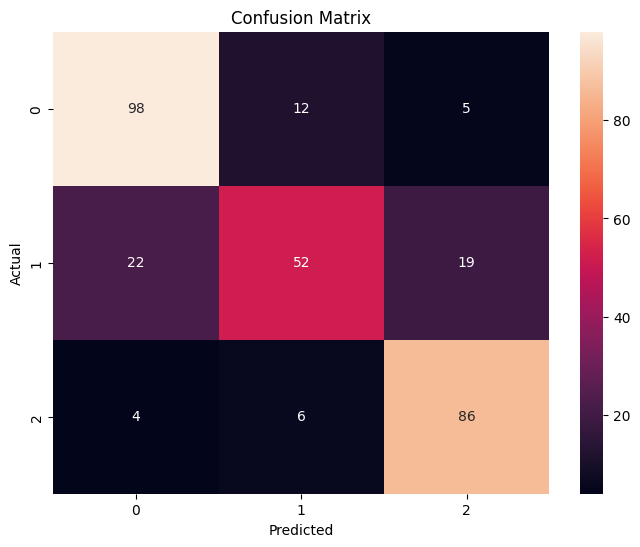

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
cm_test = metrics.confusion_matrix(y_true = y_test, y_pred = y_test_pred_mnb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

5. SVM


In [27]:
from sklearn import svm

#Use Radial Basis Function kernel
rbf = svm.SVC()

# Fit mô hình trên train data
rbf.fit(X_train_vectors, y_train)

# Predict trên test data
y_test_pred_rbf = rbf.predict(X_test_vectors)

In [28]:
import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(y_true = y_test, y_pred = y_test_pred_rbf)
print(f'The test accuracy is: {accuracy}')

f1_score = metrics.f1_score(y_true = y_test, y_pred = y_test_pred_rbf, average = None)
print(f'The test f1_score is: {f1_score}')

f1_micro = metrics.f1_score(y_true = y_test, y_pred = y_test_pred_rbf, average = 'micro')
print(f'The test f1_micro is: {f1_micro}')

f1_macro = metrics.f1_score(y_true = y_test, y_pred = y_test_pred_rbf, average = 'macro')
print(f'The test f1_macro is: {f1_macro}')

The test accuracy is: 0.8125
The test f1_score is: [0.83116883 0.72631579 0.87700535]
The test f1_micro is: 0.8125
The test f1_macro is: 0.8114966560786995


In [29]:
from sklearn.metrics import classification_report

# Xuất ra classification report
print(classification_report(y_test, y_test_pred_rbf))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       115
           1       0.71      0.74      0.73        93
           2       0.90      0.85      0.88        96

    accuracy                           0.81       304
   macro avg       0.81      0.81      0.81       304
weighted avg       0.82      0.81      0.81       304



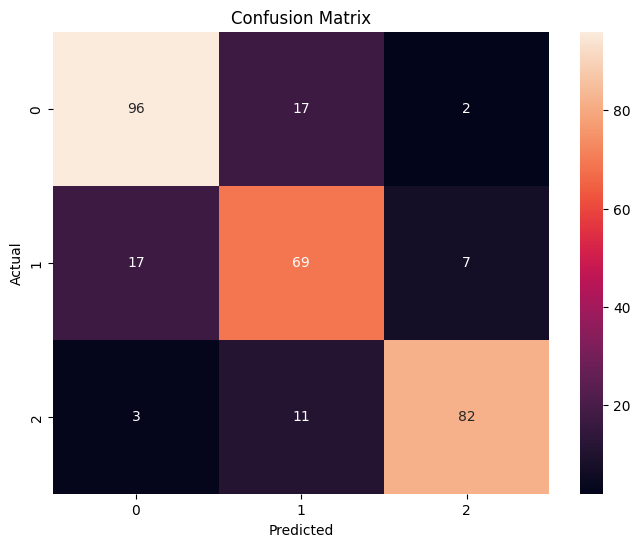

In [30]:
cm_test_rbf = metrics.confusion_matrix(y_true = y_test, y_pred = y_test_pred_rbf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_rbf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 6. Compare Result
- So sánh kết quả ở các độ đo: Accuracy, F1-score, Precision, Recall
- SVM là mô hình tốt hơn ở hầu hết các score



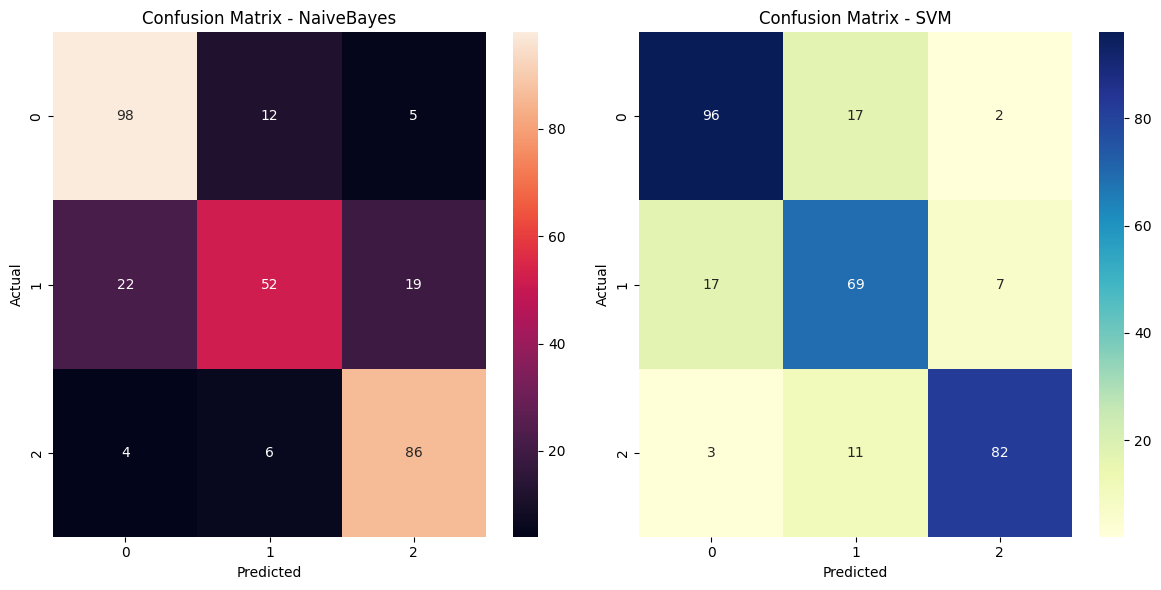

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
cm_test = metrics.confusion_matrix(y_true = y_test, y_pred = y_test_pred_mnb)
cm_test_rbf = metrics.confusion_matrix(y_true = y_test, y_pred = y_test_pred_rbf)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(cm_test, ax = ax1, annot=True, fmt="d")
ax1.set_title("Confusion Matrix - NaiveBayes")
ax1.set_xlabel("Predicted")
ax1.set_ylabel("Actual")

sns.heatmap(cm_test_rbf, ax = ax2, cmap="YlGnBu", annot=True, fmt="d")  # Customize colormap and interpolation
ax2.set_title("Confusion Matrix - SVM")
ax2.set_xlabel("Predicted")
ax2.set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

def classification_eval(y_test, y_pred):
    accuracy  = round(accuracy_score(y_test, y_pred) * 100, 2)
    precision = round(precision_score(y_test, y_pred, average='weighted') * 100, 2)
    recall    = round(recall_score(y_test, y_pred, average='weighted') * 100, 2)
    f1        = round(f1_score(y_test, y_pred, average='weighted') * 100, 2)
    return accuracy, precision, recall, f1

accuracy_svm, precision_svm, recall_svm, f1_svm = classification_eval(y_test, y_test_pred_rbf)
accuracy_nb, precision_nb, recall_nb, f1_nb = classification_eval(y_test, y_test_pred_mnb)

results = pd.DataFrame({
    'Model': ['SVM','NB'],
    'Accuracy': [accuracy_svm,accuracy_nb],
    'Precision': [precision_svm,precision_nb],
    'Recall': [recall_svm,recall_nb],
    'F1 Score': [f1_svm,f1_nb]
})

# In ra kết quả
print(tabulate(results, headers='keys', tablefmt='pretty', showindex=False))

+-------+----------+-----------+--------+----------+
| Model | Accuracy | Precision | Recall | F1 Score |
+-------+----------+-----------+--------+----------+
|  SVM  |  81.25   |   81.52   | 81.25  |  81.36   |
|  NB   |  77.63   |   77.31   | 77.63  |  76.91   |
+-------+----------+-----------+--------+----------+
